# Lab 5: Robust Mixture Models

The goal of this lab session is to study robust mixture models. You will code the EM algorithm to estimate the parameters of a mixture of multivariate t-distributions. 

You have to send the filled notebook named **"L5_familyname1_familyname2.ipynb"** (groups of 2) by email to aml.centralesupelec.2019@gmail.com before October 31 at 23:59. Please put **"AML-L5"** in the subject. 

We begin with the standard imports:

In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
#import seaborn as sns
import math
%matplotlib inline
#sns.set_context('poster')
#sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

We also define the GMM class from Lab 4:

In [2]:
class my_GMM():
    
    def __init__(self, k, tol=1e-2, itermax=25):
        '''
        Parameters:
        k: integer
            number of components
        tol: float
            convergence tolerance
       
        Attributes:
        
        alpha_: np.array
            proportion of components
        mu_: np.array
            array containing means
        Sigma_: np.array
            array cointaining covariance matrix
        cond_prob_: (n, K) np.array
            conditional probabilities for all data points 
        labels_: (n, ) np.array
            labels for data points
        '''
        self.k_ = k
        self.tol_ = tol
        self.itermax_ = itermax
        
        self.alpha_ = None
        self.mu_ = None
        self.Sigma_ = None
        self.cond_prob_ = None
        self.labels_ = None
        
        self.history = {}
        
    def gauss_pdf(self, x_i, mu, Sigma):
        """
        Computes the PDF of a Gaussian distribution of parameters Sigma and mu,
        evaluated in point x_i
        
        Parameters:
        -----------
        x_i: (p, ) np.array
            Point of evaluation
        
        mu: (p, ) np.array
            Estimator of the mean
            
        Sigma: (p, p) np.array
            Variance matrix estimator
        
        Returns:
        -----
        Evaluation of the PDF
        """
        C = 1/(np.sqrt(2 * np.pi * np.linalg.det(Sigma)))
        Sigma_inv = np.linalg.inv(Sigma) # np.linalg.pinv(Sigma)
        dev = (x_i - mu).reshape(-1, 1)
        #print(C, Sigma, np.linalg.det(Sigma))
        exp = np.exp(-0.5 * dev.T @ Sigma_inv @ dev)
        return C * exp
        
    def fit(self, X):
        """ Find the parameters
        that better fit the data
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """    
        self.has_converged = False
        
        # Initialize parameters estimators
        self.alpha_, self.mu_, self.Sigma_ = self.init_params(X, self.k_)
        
        self.history = {"cpm": [], "alpha": [], "mu": [], "Sigma": []}
        
        itr = 0
        while not self.has_converged and itr < self.itermax_:
            itr += 1
            # E-step: compute conditional probability matrix
            self.cond_prob_ = self.compute_proba(X=X, alpha=self.alpha_, mu=self.mu_, Sigma=self.Sigma_)
            
            self.history["cpm"].append(self.cond_prob_)
            self.history["alpha"].append(self.alpha_)
            self.history["mu"].append(self.mu_)
            self.history["Sigma"].append(self.Sigma_)
            
            # M-step: update parameters estimators
            new_alpha = self.update_alpha(cpm=self.cond_prob_)
            new_mu = self.update_mu(X=X, cpm=self.cond_prob_, alpha=new_alpha)
            new_Sigma = self.update_Sigma(X=X, cpm=self.cond_prob_, alpha=new_alpha, mu=new_mu)
            
            old_params = (self.alpha_, self.mu_, self.Sigma_)
            new_params = (new_alpha, new_mu, new_Sigma)
            
            self.has_converged = self.evaluate_convergence(X, old_params=old_params, new_params=new_params)
            
            self.alpha_ = new_alpha
            self.mu_ = new_mu
            self.Sigma_ = new_Sigma
        
        self.labels_ = self.predict(X)
        return self
        
    def predict(self, X):
        """ Predict labels for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        label assigment        
        """ 
        n= X.shape[0]
        labels = np.argmax(self.cond_prob_, axis=1)
        return labels
    
    def evaluate_convergence(self, X, old_params, new_params):
        """Returns wether the algorithm has converged
        """
        return abs(self.log_likelihood(X, *old_params) - self.log_likelihood(X, *new_params)) <= self.tol_
        
    def compute_proba(self, X, alpha, mu, Sigma):
        """ Compute probability vector for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        proba: (n, k) np.array        
        """
        n = X.shape[0]
        k = self.k_

        prob_matrix = np.zeros(shape=(n, k))

        for i in range(n):
            x_i = X[i]
            joint_law = 1e-4
            for j in range(k):
                prob_matrix[i, j] = alpha[j] * self.gauss_pdf(x_i=x_i, mu=mu[j], Sigma=Sigma[j])
                joint_law += prob_matrix[i, j]
            prob_matrix[i, :] /= joint_law
        
        return prob_matrix
    
    def init_params(self, X, K):
        """Initialize parameters estimators
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        K: int
            Number of classes / clusters
        
        Returns:
        -----
        ((k,) np.array, (k, p) np.array, (k, p, p) np.array) tuple
            Tuple of 3 np.arrays: (alpha0, mu0, Sigma0)
        """        
        n = X.shape[0]
        p = X.shape[1]
        
        from sklearn.cluster import KMeans
        k_means = KMeans(n_clusters=K).fit(X)
        X_labels = k_means.labels_
        
        mu0 = k_means.cluster_centers_
        Sigma0 = []
        alpha0 = []
        
        for k, count in zip(*np.unique(X_labels, return_counts=True)):
            X_k = np.array([X[i] for i in range(n) if X_labels[i] == k])
            Sigma0.append(np.cov(X_k.T) + 1e-3 * np.eye(p))
            alpha0.append(count/n)
        Sigma0 = np.array(Sigma0)
        alpha0 = np.array(alpha0)
        
        return (alpha0, mu0, Sigma0)
    
    def update_alpha(self, cpm):
        """Returns the updated version of alpha (cluster proportion estimators)
        
        Parameters:
        -----------
        cpm: (n, k) np.array
            Conditional probability matrix

        Returns:
        -----
        (k,) np.array
            The new estimators for cluster proportion
        """
        new_alpha = np.mean(cpm, axis=0)
        return new_alpha
    
    def update_mu(self, X, cpm, alpha):
        """Returns the updated version of mu (cluster mean estimators)
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data
        
        cpm: (n, k) np.array
            Conditional probability matrix
        
        alpha: (k, ) np.array
            Current estimators for the clusters' proportions
        
        Returns:
        -----
        (k, p) np.array
            The new estimators for clusters' means
        """
        n = X.shape[0]
        k = cpm.shape[1]   
        p = X.shape[1]

        new_mu = np.zeros(shape=(k, p))

        for j in range(k):
            for i in range(n):
                new_mu[j] += X[i] * cpm[i, j]
            new_mu[j] /= (alpha[j] * n)

        return new_mu

    def update_Sigma(self, X, cpm, alpha, mu):
        """Returns the updated version of Sigma (cluster mean estimators)
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data
        
        cpm: (n, k) np.array
            Conditional probability matrix
        
        alpha: (k, ) np.array
            Current estimators for the clusters' proportions
        
        mu: (k, p) np.array
            Current estimators for the clusters' means
        
        Returns:
        -----
        (k, p, p) np.array
            The new estimators for clusters' variances
        """
        n = X.shape[0]
        k = cpm.shape[1]
        p = X.shape[1]
        
        new_Sigma = np.zeros(shape=(k, p, p))
        
        for j in range(k):
            for i in range(n):
                deviation = (X[i] - mu[j]).reshape(-1, 1)
                new_Sigma[j] += deviation@deviation.T * cpm[i, j]
            new_Sigma[j] /= (alpha[j] * n)
        
        return new_Sigma
    
    def log_likelihood(self, X, alpha, mu, Sigma):
        """Returns whether the algorithm has converged
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data
        
        alpha: (k, ) np.array
            Current estimators for the clusters' proportions
        
        mu: (k, p) np.array
            Current estimators for the clusters' means
            
        Sigma: (k, p, p) np.array
            Current estimators for clusters' variances
        
        Returns:
        -----
        float
            log-likelihood for the given parameters
        """
        l = 0
        n = X.shape[0]
        k = alpha.shape[0]
        
        for i in range(n):
            x_i = X[i]
            inner = 0
            for j in range(k):
                inner += alpha[j] * self.gauss_pdf(x_i=x_i, mu=mu[j], Sigma=Sigma[j])
            l += np.log(inner)
        return l

And then define a function to quantitatively evaluate th performances of our models:

## $t$MM

Reference: https://people.smp.uq.edu.au/GeoffMcLachlan/pm_sc00.pdf 

### 1 - Prove that in the $t$MM model

$$U_i|(X_i=x_i,Z_{ij}=1) \sim \Gamma\left(\frac{\nu_j+p}{2}, \frac{\nu_j+(x_i-\mu_j)^T\Sigma_j^{-1}(x_i-\mu_j)}{2}\right)$$

Since $$f_{U_i|X_i=x_i,Z_{i,j}=1}(u_i) = \frac{f_{U_i|Z_{i,j}=1}(u_i)f_{X_i|U_i=u_i,Z_{i,j}=1}(x_i)}{f_{X_i|Z_{i,j}=1}(x_i)}$$
one has $$
\left\{
\begin{array}{}
f_{U_i|Z_{i,j}=1}(u_i) = \frac{(\frac{\nu_j}{2})^{\frac{\nu_j}{2}}}{\Gamma({\frac{\nu_j}{2}})}u_i^{\frac{\nu_j}{2}-1}e^{-\frac{\nu_j}{2}u_i}\mathbb{1}_{\mathbb{R}_{+}}(u_i)\\
f_{X_i|U_i=u_i,Z_{i,j}=1}(x_i) = \frac{1}{(2\pi)^{\frac{p}{2}}|\frac{\Sigma_j}{u_i}|^{\frac{1}{2}}}e^{-\frac{1}{2}(x_i-\mu_j)^{T}(\frac{\Sigma_j}{u_i})^{-1}(x_i-\mu_j)}\\
f_{X_i|Z_{i,j}=1}(x_i) = \frac{\Gamma(\frac{\nu_j+p}{2})|\Sigma_j|^{-\frac{1}{2}}(1+\frac{(x_i-\mu_j)^{T}\Sigma_j^{-1}(x_i-\mu_j)}{\nu_j})^{\frac{\nu_j+p}{2}}}{(\pi\nu_j)^{\frac{p}{2}}\Gamma(\frac{\nu_j}{2})}\\
\end{array}
\right.
$$
and given that $$|\frac{\Sigma_j}{u_i}| = \frac{|\Sigma_j|}{u_i^p}$$
and $$(\frac{1}{u_i}\Sigma_j)^{-1} = u_i\Sigma_j^{-1}$$

gives directly : 

$$f_{U_i|X_i=x_i,Z_{i,j}=1}(u_i) = \frac{(\frac{\nu_j+(x_i-\mu_j)^{T}\Sigma_j^{-1}(x_i-\mu_j)}{2})^{\frac{\nu_j+p}{2}}}{\Gamma(\frac{\nu_j+p}{2})}u^{\frac{\nu_j+p}{2}-1}e^{-\frac{u_i}{2}(x_i-\mu_j)^{T}\Sigma_j^{-1}(x_i-\mu_j)}\mathbb{1}_{\mathbb{R}_{+}}(u_i)$$

We recognize the law of a $\Gamma$, and as a law can be identified by its probability density function, we obtain the result. 

### 2 - Fill in the following class to implement EM for a multivariate $t$MM. You can use the gamma and digamma functions and also a solver to find roots. 

In [3]:
class my_tMM():
    
    def __init__(self, K, itermax=25, tol=1e-2):
        '''
        Parameters:
        -----------
        K: integer
            number of components
        
        Attributes:
        -----------
        alpha_: np.array
            proportion of components
        mu_: np.array
            array containing means
        Sigma_: np.array
            array cointaining covariance matrix
        cond_prob_: (n, K) np.array
            conditional probabilities for all data points 
        u_: (n, K) np.array
            expectation of the U variable 
        dof_: (K, ) np.array
            degrees of freedom of each component
        labels_: (n, ) np.array
            labels for data points
        '''
        
        self.K_ = K
        self.itermax_ = itermax
        self.alpha_ = None
        self.mu_ = None
        self.Sigma_ = None
        self.cond_prob_ = None
        self.labels_ = None
        self.dof_ = None
        self.u_ = None
        self.tol_ = tol
        
        self.history_ = {}
        
    def sqr_mahalanobis(self, x, mu, Sigma):
        # compute the squared Mahalanobis distance
        deviation = (x-mu).reshape(-1,1)
        return deviation.T @ np.linalg.inv(Sigma) @ deviation
    
    def student_pdf(self, x_i, mu, Sigma, dof):
        """
        Compute the PDF of a multivariate Student's t-distribution of parameters mu, Sigma and dof
        evaluated in point x_i.
        
        Parameters:
        -----------
        x_i: (p, ) np.array
            Point of evaluation
        
        mu: (p, ) np.array
            Estimator of the mean
            
        Sigma: (p, p) np.array
            Variance matrix estimator
        
        dof: 
        
        Returns:
        -----
        Evaluation of the PDF
        """
        from scipy.special import gamma
        
        p = x_i.shape[0]
        
        num = gamma((dof + p)/2)*1/(np.sqrt(np.linalg.det(Sigma)))# + 1e-3)
        den = ((np.pi*dof)**(p/2) * gamma(dof/2) * 
               (1 + self.sqr_mahalanobis(x_i, mu, Sigma)/dof)**((dof+p)/2))
        
        return num/den
    
        
    def fit(self, X):
        """ Find the parameters
        that better fit the data
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """
        
        n = X.shape[0]
        p = X.shape[1]
        self.has_converged = False
        
        
        # Initialize parameters estimators
        self.cond_prob_, self.u_, self.alpha_, self.mu_, self.Sigma_, self.dof_ = self.init_params(X, self.K_)
        
        self.history_ = {
            "cond_prob": [self.cond_prob_],
            "u": [self.u_],
            "alpha": [self.alpha_],
            "mu": [self.mu_],
            "sigma": [self.Sigma_],
            "dof": [self.dof_],
            "l": [self.log_likelihood(X, self.cond_prob_, self.mu_, self.Sigma_, self.dof_, self.u_)]
        }
        
        itr = 0
        while itr < self.itermax_ and not self.has_converged:
            itr += 1
            # E-step: update cond_prob_ and u_
            new_cond_prob = self.compute_proba(X, alpha=self.alpha_, mu=self.mu_, Sigma=self.Sigma_, dof=self.dof_)
            new_u = self.update_u(X=X, mu=self.mu_, Sigma=self.Sigma_, dof=self.dof_)
            
            # M-step: update parameters estimators
            #      - alpha the proportions of the clusters
            #      - mu and Sigma values for maximizing the likelihood
            #      - the degrees of freedom variable
            new_alpha = np.mean(new_cond_prob, axis=0)
            new_mu = self.update_mu(X=X, cpm=new_cond_prob, u=new_u)
            new_Sigma = self.update_Sigma(X=X, cpm=new_cond_prob, mu=new_mu, u=new_u)
            new_dof = self.update_dof(cpm=new_cond_prob, p=p, old_dof=self.dof_, u=new_u)
            
            self.history_["cond_prob"].append(new_cond_prob)
            self.history_["u"].append(new_u)
            self.history_["alpha"].append(new_alpha)
            self.history_["mu"].append(new_mu)
            self.history_["sigma"].append(new_Sigma)
            self.history_["dof"].append(new_dof)
            self.history_["l"].append(self.log_likelihood(X, self.cond_prob_, self.mu_, self.Sigma_, self.dof_, self.u_))
            
            
            old_params = (self.cond_prob_, self.mu_, self.Sigma_, self.dof_, self.u_)
            new_params = (new_cond_prob, new_mu, new_Sigma, new_dof, new_u)
            
            self.has_converged = self.evaluate_convergence(X, old_params=old_params, new_params=new_params)
            
            self.cond_prob_ = new_cond_prob
            self.u_ = new_u
            
            self.alpha_ = new_alpha
            self.mu_ = new_mu
            self.Sigma_ = new_Sigma
            self.dof_ = new_dof
            
        
        # Update labels
        self.labels_ = self.predict(X)
        return self
    
    
    def evaluate_convergence(self, X, old_params, new_params):
        """Returns wether the algorithm has converged
        """
        return abs(self.log_likelihood(X, *old_params) - self.log_likelihood(X, *new_params)) <= self.tol_
        
    def compute_proba(self, X, alpha, mu, Sigma, dof):
        """ Compute probability vector for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        proba: (n, k) np.array        
        """        
        n = X.shape[0]
        k = self.K_

        prob_matrix = np.zeros(shape=(n, k))

        for i in range(n):
            joint_law = 0
            x_i = X[i]
            for j in range(k):
                prob_matrix[i, j] = alpha[j] * self.student_pdf(x_i=x_i, mu=mu[j], Sigma=Sigma[j], dof=dof[j])
                joint_law += prob_matrix[i,j]
            prob_matrix[i, :] /= joint_law
            
        return prob_matrix
    
    def init_params(self, X, K):
        """Initialize parameters estimators
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        K: int
            Number of classes / clusters
        
        Returns:
        -----
        ((k,) np.array, (k, p) np.array, (k, p, p) np.array) tuple
            Tuple of 3 np.arrays: (alpha0, mu0, Sigma0)
        """       
        from sklearn.cluster import KMeans
        
        n = X.shape[0]
        p = X.shape[1]
        u0 = np.ones((n, K))
        cond_prob0 = np.ones((n, K))/K
        
        k_means = KMeans(n_clusters=K, max_iter=50).fit(X)
        X_labels = k_means.labels_
        mu0 = k_means.cluster_centers_
        Sigma0 = []
        alpha0 = []
        
        for k, count in zip(*np.unique(X_labels, return_counts=True)):
            X_k = np.array([X[i] for i in range(n) if X_labels[i] == k])
            Sigma0.append(np.cov(X_k.T) + 1e-3 * np.eye(p))
            alpha0.append(count/n)
        Sigma0 = np.array(Sigma0)
        alpha0 = np.array(alpha0)
        
        dof0 = np.random.rand(K)
                
        return (cond_prob0, u0, alpha0, mu0, Sigma0, dof0)
    
    def update_mu(self, X, cpm, u):
        """Returns the updated version of mu (cluster mean estimators)
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data
        
        cpm: (n, k) np.array
            Conditional probability matrix
        
        alpha: (k, ) np.array
            Current estimators for the clusters' proportions
        
        Returns:
        -----
        (k, p) np.array
            The new estimators for clusters' means
        """
        n = cpm.shape[0]
        k = cpm.shape[1]   
        p = X.shape[1]
        
        cpm_u = np.multiply(cpm, u)
        new_mu = cpm_u.T@X
        for j in range(k):
            new_mu[j] /= np.sum(cpm_u[:,j])

        return new_mu

    def update_Sigma(self, X, cpm, mu, u):
        """Returns the updated version of Sigma (cluster mean covariances)
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data
        
        cpm: (n, k) np.array
            Conditional probability matrix
        
        alpha: (k, ) np.array
            Current estimators for the clusters' proportions
        
        mu: (k, p) np.array
            Current estimators for the clusters' means
        
        Returns:
        -----
        (k, p, p) np.array
            The new estimators for clusters' variances
        """
        n = cpm.shape[0]
        k = self.K_
        p = X.shape[1]
        
        new_Sigma = np.zeros(shape=(k, p, p))
        
        cpm_u = np.multiply(cpm, u)
        
        cpm_tot = np.sum(cpm,axis=0)
        for j in range(k):
            for i in range(n):
                deviation = (X[i] - mu[j]).reshape(-1,1)
                new_Sigma[j] += cpm_u[i, j] * (deviation @ deviation.T)
            new_Sigma[j] /= cpm_tot[j]
            
        return new_Sigma
    
    def function_dof(self, dof, old_dof, cond_prob, u, p):
        # function to find dof
        from scipy.special import digamma as psi
        
        num = np.diag((np.log(u) - u).T @ cond_prob).reshape(self.K_, )
        den = np.sum(cond_prob, axis=0)
        
        return -psi(dof/2) + np.log(dof/2) + 1 + psi((old_dof+p)/2) - np.log((old_dof+p)/2) + num/den
       
    def update_dof(self, cpm, p, old_dof, u):
        """Returns the updated version of dof (cluster mean degree of liberty)
        
        Parameters:
        -----------
        cpm: (n, k) np.array
            Conditional probability matrix
            
        p: int
            The dimension of the data
        
        old_dof: (k, ) np.array
            Old estimators for the clusters' degree of freedom
        
        u: (n, k) np.array
            Current estimators for the clusters' latent variable u
        
        Returns:
        -----
        (k, ) np.array
            New estimators for clusters' degree of freedom
        """
        from scipy.optimize import root
        
        new_dof = root(self.function_dof, args=(old_dof, cpm, u, p), x0=old_dof).x
        
        return new_dof
    
    def update_u(self, X, mu, Sigma, dof):
        """Returns the updated version of u
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data
        
        cpm: (n, k) np.array
            Conditional probability matrix
        
        alpha: (k, ) np.array
            Current estimators for the clusters' proportions
        
        mu: (k, p) np.array
            Current estimators for the clusters' means
        
        Returns:
        -----
        (n, k) np.array
            The new u
        """
        n = X.shape[0]
        k = self.K_
        p = X.shape[1]
        
        new_u = np.zeros(shape=(n, k))
        
        for j in range(k):
            num = dof[j] + p
            for i in range(n):
                den = dof[j] + (X[i]-mu[j]).T @ np.linalg.inv(Sigma)[j] @ (X[i]-mu[j])
                new_u[i,j] = num/den
        
        return new_u
    
    def gauss_pdf(self, x_i, mu, Sigma):
        """
        Computes the PDF of a Gaussian of parameters Sigma and mu,
        evaluated in point x_i
        
        Parameters:
        -----------
        x_i: (p, ) np.array
            Point of evaluation
        
        mu: (p, ) np.array
            Estimator of the mean
            
        Sigma: (p, p) np.array
            Variance matrix estimator
        
        Returns:
        -----
        Evaluation of the PFD
        """
        C = 1/(np.sqrt(2 * np.pi * np.linalg.det(Sigma)))
        Sigma_inv = np.linalg.inv(Sigma)
        exp = np.exp(-0.5 * (x_i - mu).T@Sigma_inv@(x_i - mu))
        return C * exp
    
    def gamma_pdf(self, u, lbda, theta):
        """
        Computes the PDF of a Gamma distribution of parameters Sigma and mu,
        evaluated in point x_i
        
        Parameters:
        -----------
        x_i: (p, ) np.array
            Point of evaluation
        
        mu: (p, ) np.array
            Estimator of the mean
            
        Sigma: (p, p) np.array
            Variance matrix estimator
        
        Returns:
        -----
        Evaluation of the PDF
        """
        from scipy.special import gamma as GAMMA
        
        idrp = (u>=0).astype('int')
        num = idrp*((theta**lbda) * (u**(lbda-1)) * (np.exp(-u*theta)))
        den = GAMMA(lbda)
        
        return num/den
    
    def log_likelihood(self, X, cpm, mu, Sigma, dof, u):
        """Returns whether the algorithm has converged
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data
        
        alpha: (k, ) np.array
            Current estimators for the clusters' proportions
        
        mu: (k, p) np.array
            Current estimators for the clusters' means
            
        Sigma: (k, p, p) np.array
            Current estimators for clusters' variances
            
        dof: (k, ) np.array
            Current estimators for clusters' degree of freedom
        
        u: (n, k) np.array
            Current estimators for the clusters' latent variable u
        
        Returns:
        -----
        float
            log-likelihood for the given parameters
        """
        l = 0
        n = X.shape[0]
        k = self.K_
        
        for i in range(n):
            x_i = X[i]
            u_i = u[i]
            for j in range(k):
                if np.argmax(cpm[i])==j:
                    PDF_1 = self.gauss_pdf(x_i, mu=mu[j], Sigma=Sigma[j])
                    lbda = theta = dof[j]/2
                    PDF_2 = self.gamma_pdf(u_i[j], lbda, theta)
                    PDF_3 = cpm[i,j]
                    l += np.log(PDF_1*PDF_2*PDF_3)
        return l
    
    
    def predict(self, X):
        """ Predict labels for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        label assigment        
        """ 
        labels = np.argmax(self.cond_prob_, axis=1)
        return labels

### 3 - Generate one dataset with mixtures of t-distributions that ilustrate when tMM and GMM behave similarly and another dataset where tMM has a better performance

Create the dataset :

#### Mixture of $t$-Student distributions:

In [6]:
n = 500
p = 2

X = []

for _ in range(3):
    mu = np.random.uniform(-4,4, (2,))
    dof = np.random.uniform(1, 8, (2,))
    pts = []
    for _ in range(400):
        pts.append(np.random.standard_t(df=dof) + mu)
    X.append(np.array(pts))

data = np.concatenate(X)

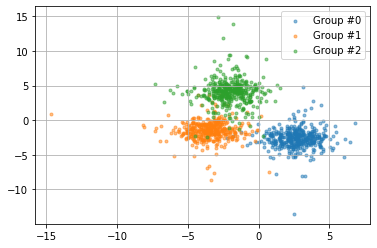

In [7]:
for i, pts in enumerate(X):
    plt.scatter(pts.T[0], pts.T[1], marker='.', label="Group #{}".format(i), alpha=0.5)
plt.legend()
plt.grid()
plt.show()

Let's train GMM and $t$MM models on this dataset:

In [8]:
gmm = my_GMM(k=3, itermax=10)
tmm = my_tMM(K=3, itermax=10)

In [9]:
gmm.fit(data)
tmm.fit(data)

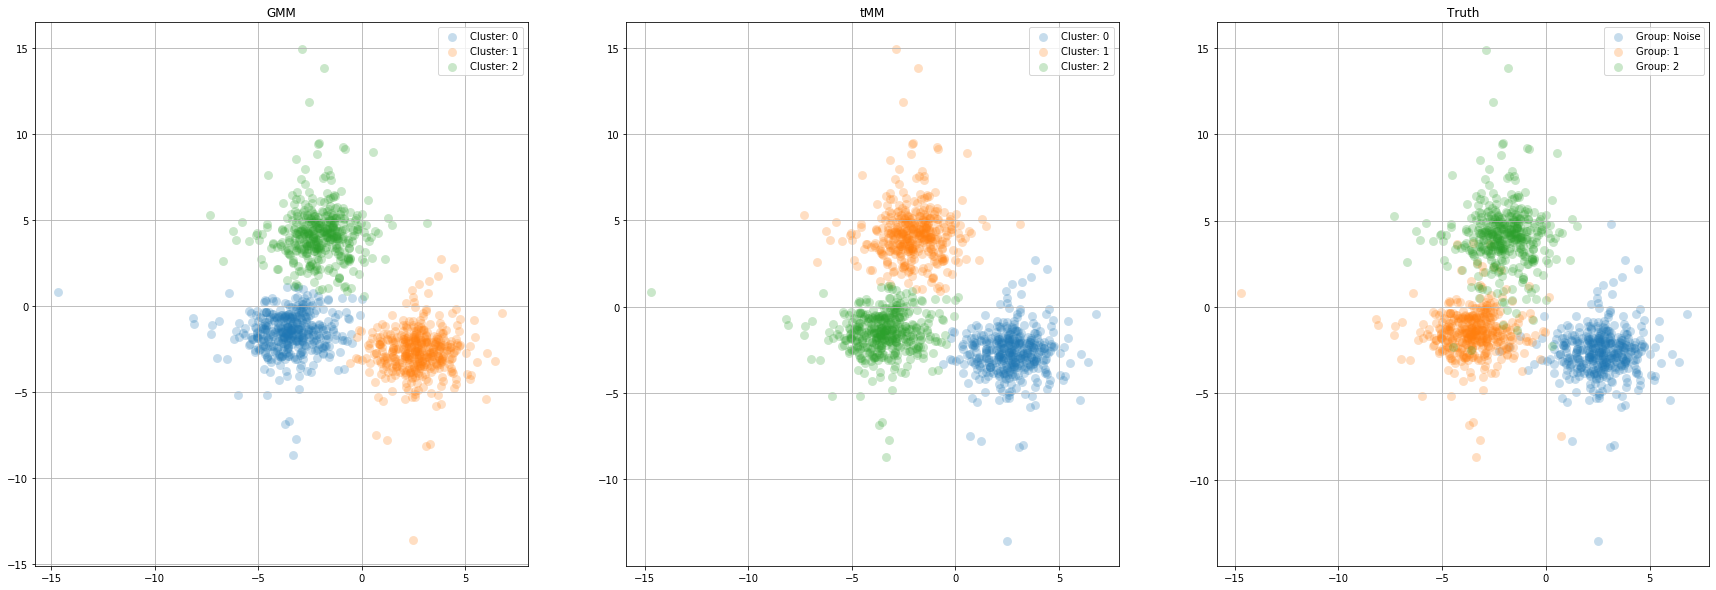

In [10]:
plt.figure(figsize=(30,10))

plt.subplot(131)
for label in np.unique(gmm.labels_):
    data_i = np.array([data[j] for j in range(data.shape[0]) if gmm.labels_[j] == label])
    plt.scatter(data_i.T[0], data_i.T[1], label="Cluster: {}".format(label), **plot_kwds)
plt.title("GMM")
plt.legend()
plt.grid()

plt.subplot(132)
for label in np.unique(tmm.labels_):
    data_i = np.array([data[j] for j in range(data.shape[0]) if tmm.labels_[j] == label])
    plt.scatter(data_i.T[0], data_i.T[1], label="Cluster: {}".format(label), **plot_kwds)
plt.title("tMM")
plt.legend()
plt.grid()

plt.subplot(133)
for i, pts in enumerate(X):
    plt.scatter(pts.T[0], pts.T[1], label="Group: {}".format(i if i else "Noise"), **plot_kwds)
plt.title("Truth")
plt.legend()
plt.grid()
plt.show()

GMM and $t$MM have similar performances on such dataset

#### Adding a uniform noise to the data:

In [22]:
n = 500
p = 2

X = [np.random.uniform(-10, 10, size=(150, p))]

for _ in range(3):
    mu = np.random.uniform(-6,6, (2,))
    sigma = np.diag(np.random.uniform(-1,1, (2,)))
    sigma = sigma.T@sigma
    pts = []
    for _ in range(400):
        pts.append(np.random.multivariate_normal(mean=mu, cov=sigma))
    X.append(np.array(pts))
data = np.concatenate(X)

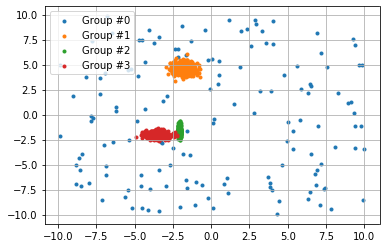

In [23]:
for i, pts in enumerate(X):
    plt.scatter(pts.T[0], pts.T[1], marker='.', label="Group #{}".format(i))
plt.legend()
plt.grid()
plt.show()

In [30]:
gmm = my_GMM(3, itermax=10)
tmm = my_tMM(3, itermax=10)

gmm.fit(data)
tmm.fit(data)

C:\Users\sbran\Anaconda3\envs\aml-tp5\lib\site-packages\ipykernel_launcher.py:463: RuntimeWarning: divide by zero encountered in log


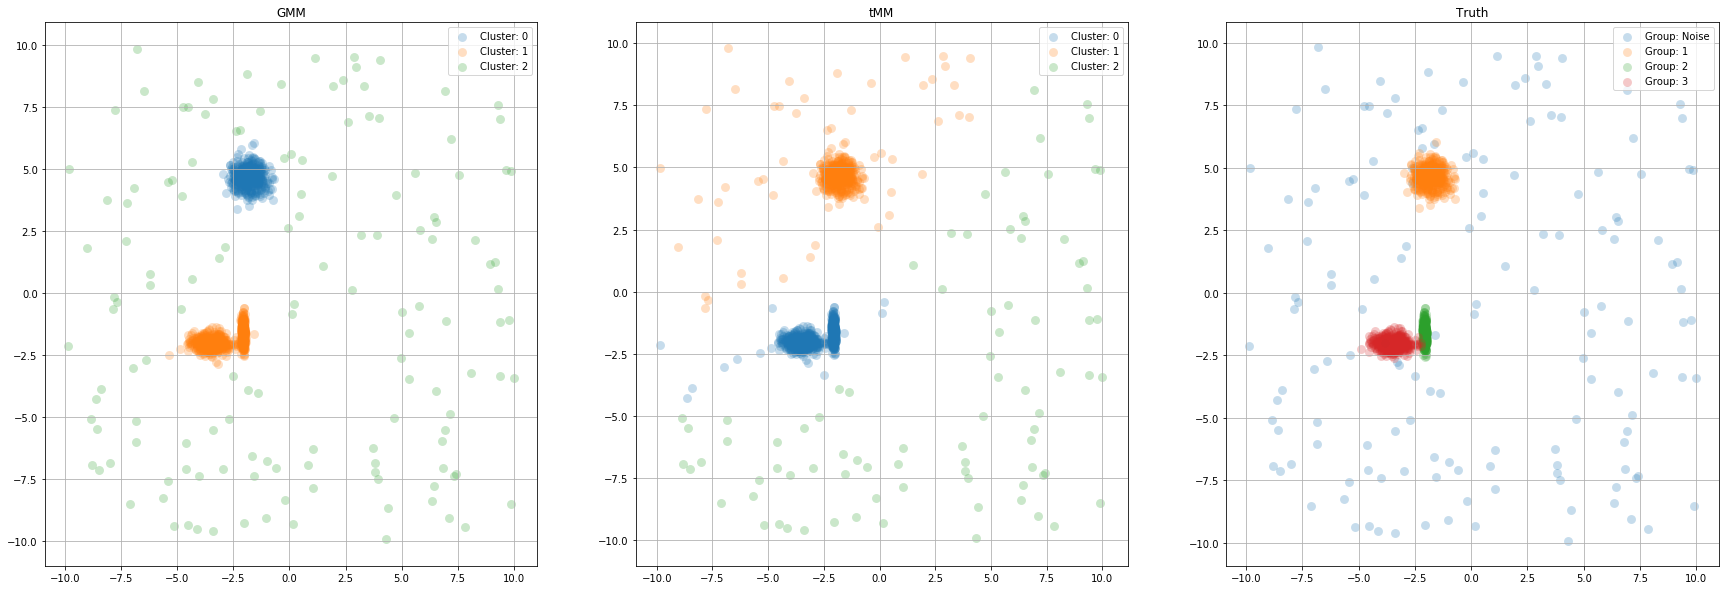

In [31]:
plt.figure(figsize=(30,10))

plt.subplot(131)
for label in np.unique(gmm.labels_):
    data_i = np.array([data[j] for j in range(data.shape[0]) if gmm.labels_[j] == label])
    plt.scatter(data_i.T[0], data_i.T[1], label="Cluster: {}".format(label), **plot_kwds)
plt.title("GMM")
plt.legend()
plt.grid()

plt.subplot(132)
for label in np.unique(tmm.labels_):
    data_i = np.array([data[j] for j in range(data.shape[0]) if tmm.labels_[j] == label])
    plt.scatter(data_i.T[0], data_i.T[1], label="Cluster: {}".format(label), **plot_kwds)
plt.title("tMM")
plt.legend()
plt.grid()

plt.subplot(133)
for i, pts in enumerate(X):
    plt.scatter(pts.T[0], pts.T[1], label="Group: {}".format(i if i else "Noise"), **plot_kwds)
plt.title("Truth")
plt.legend()
plt.grid()
plt.show()

On this particular dataset, the GMM model performs "better" than the tMM model, in the way it spots the uniform noise in a separate cluster.

### 4 - Modify the my_GMM class to implement the Extra Uniform Cluster Algorithm

We modify our code to implement the *Extra Uniform Cluster* method :

In [136]:
class my_GMM_EU(my_GMM):
    
    def fit(self, X):
        """ Find the parameters
        that better fit the data
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """    
        self.has_converged = False
        self.vol_ = (np.max(X.T[0]) - np.min(X.T[0]))*(np.max(X.T[1]) - np.min(X.T[1]))
        
        # Initialize parameters estimators
        self.alpha_, self.mu_, self.Sigma_ = self.init_params(X, self.k_, self.vol_)
        
        self.history = {"cpm": [], "alpha": [], "mu": [], "Sigma": []}
        
        itr = 0
        while not self.has_converged and itr < self.itermax_:
            itr += 1
            # E-step: compute conditional probability matrix
            self.cond_prob_ = self.compute_proba(X=X, alpha=self.alpha_, mu=self.mu_, Sigma=self.Sigma_)
            
            # M-step: update parameters estimators
            new_alpha = self.update_alpha(cpm=self.cond_prob_)
            new_mu = self.update_mu(X=X, cpm=self.cond_prob_, alpha=new_alpha)
            new_Sigma = self.update_Sigma(X=X, cpm=self.cond_prob_, alpha=new_alpha, mu=new_mu)
            
            old_params = (self.alpha_, self.mu_, self.Sigma_)
            new_params = (new_alpha, new_mu, new_Sigma)
            
            self.has_converged = self.evaluate_convergence(X, old_params=old_params, new_params=new_params)
            
            self.alpha_ = new_alpha
            self.mu_ = new_mu
            self.Sigma_ = new_Sigma
        
        self.labels_ = self.predict(X)
        return self
        
        
    def compute_proba(self, X, alpha, mu, Sigma):
        """ Compute probability vector for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        proba: (n, k) np.array        
        """
        n = X.shape[0]
        k = self.k_

        prob_matrix = np.zeros(shape=(n, k+1))

        for i in range(n):
            x_i = X[i]
            prob_matrix[i, 0] = joint_law = alpha[0] / self.vol_
            for j in range(1, k+1):
                prob_matrix[i, j] = alpha[j] * self.gauss_pdf(x_i=x_i, mu=mu[j], Sigma=Sigma[j-1])
                joint_law += prob_matrix[i, j]
            prob_matrix[i, :] /= joint_law
        
        return prob_matrix
    
    def init_params(self, X, K, vol):
        """Initialize parameters estimators
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        K: int
            Number of classes / clusters
        
        Returns:
        -----
        ((k,) np.array, (k, p) np.array, (k, p, p) np.array) tuple
            Tuple of 3 np.arrays: (alpha0, mu0, Sigma0)
        """        
        n = X.shape[0]
        p = X.shape[1]
        
        from sklearn.cluster import KMeans
        k_means = KMeans(n_clusters=K).fit(X)
        X_labels = k_means.labels_
        
        mu0 = np.concatenate(([np.zeros((p,))], k_means.cluster_centers_))
        Sigma0 = []
        alpha0 = [1/vol, ]
        
        for k, count in zip(*np.unique(X_labels, return_counts=True)):
            X_k = np.array([X[i] for i in range(n) if X_labels[i] == k])
            Sigma0.append(np.cov(X_k.T) + 1e-3 * np.eye(p))
            alpha0.append((count-1/vol)/n)
        Sigma0 = np.array(Sigma0)
        alpha0 = np.array(alpha0)
        
        return (alpha0, mu0, Sigma0)
    
    def update_alpha(self, cpm):
        """Returns the updated version of alpha (cluster proportion estimators)
        
        Parameters:
        -----------
        cpm: (n, k) np.array
            Conditional probability matrix

        Returns:
        -----
        (k,) np.array
            The new estimators for cluster proportion
        """
        n = cpm.shape[0]
        k = self.k_

        new_alpha = np.zeros((k + 1,))
        for j in range(k+1):
            new_alpha[j] = np.sum(cpm[:, j]) / n
        return new_alpha
    
    def update_mu(self, X, cpm, alpha):
        """Returns the updated version of mu (cluster mean estimators)
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data
        
        cpm: (n, k) np.array
            Conditional probability matrix
        
        alpha: (k, ) np.array
            Current estimators for the clusters' proportions
        
        Returns:
        -----
        (k, p) np.array
            The new estimators for clusters' means
        """
        n = cpm.shape[0]
        k = self.k_ 
        p = X.shape[1]

        new_mu = np.zeros(shape=(k+1, p))

        for j in range(k+1):
            for i in range(n):
                new_mu[j] += X[i] * cpm[i, j]
            new_mu[j] /= (alpha[j] * n)

        return new_mu

    def update_Sigma(self, X, cpm, alpha, mu):
        """Returns the updated version of Sigma (cluster mean estimators)
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data
        
        cpm: (n, k) np.array
            Conditional probability matrix
        
        alpha: (k, ) np.array
            Current estimators for the clusters' proportions
        
        mu: (k, p) np.array
            Current estimators for the clusters' means
        
        Returns:
        -----
        (k, p, p) np.array
            The new estimators for clusters' variances
        """
        n = cpm.shape[0]
        k = self.k_
        p = X.shape[1]
        
        new_Sigma = np.zeros(shape=(k, p, p))
        
        for j in range(k):
            for i in range(n):
                deviation = (X[i] - mu[j+1]).reshape(-1, 1)
                new_Sigma[j] += deviation@deviation.T * cpm[i, j+1]
            new_Sigma[j] /= (alpha[j+1] * n)
        
        return new_Sigma
    
    def log_likelihood(self, X, alpha, mu, Sigma):
        """Returns whether the algorithm has converged
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data
        
        alpha: (k, ) np.array
            Current estimators for the clusters' proportions
        
        mu: (k, p) np.array
            Current estimators for the clusters' means
            
        Sigma: (k, p, p) np.array
            Current estimators for clusters' variances
        
        Returns:
        -----
        float
            log-likelihood for the given parameters
        """
        l = 0
        n = X.shape[0]
        k = self.k_
        
        for i in range(n):
            x_i = X[i]
            inner = alpha[0] / self.vol_
            for j in range(1,k+1):
                inner += alpha[j] * self.gauss_pdf(x_i=x_i, mu=mu[j], Sigma=Sigma[j-1])
            l += np.log(inner)
        return l

#### Test on a dataset

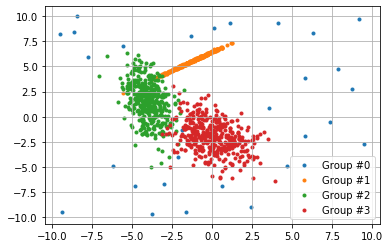

In [137]:
n = 500
p = 2

X = [np.random.uniform(-10, 10, size=(30, p))]

for _ in range(3):
    mu = np.random.uniform(-6,6, (2,))
    sigma = np.random.uniform(-2,2, (2,2))
    sigma = sigma.T@sigma
    pts = []
    for _ in range(400):
        pts.append(np.random.multivariate_normal(mean=mu, cov=sigma))
    X.append(np.array(pts))

for i, pts in enumerate(X):
    plt.scatter(pts.T[0], pts.T[1], marker='.', label="Group #{}".format(i))
plt.legend()
plt.grid()
plt.show()

In [138]:
data = np.concatenate(X)
gmm_eu = my_GMM_EU(3)
gmm_eu.fit(data)

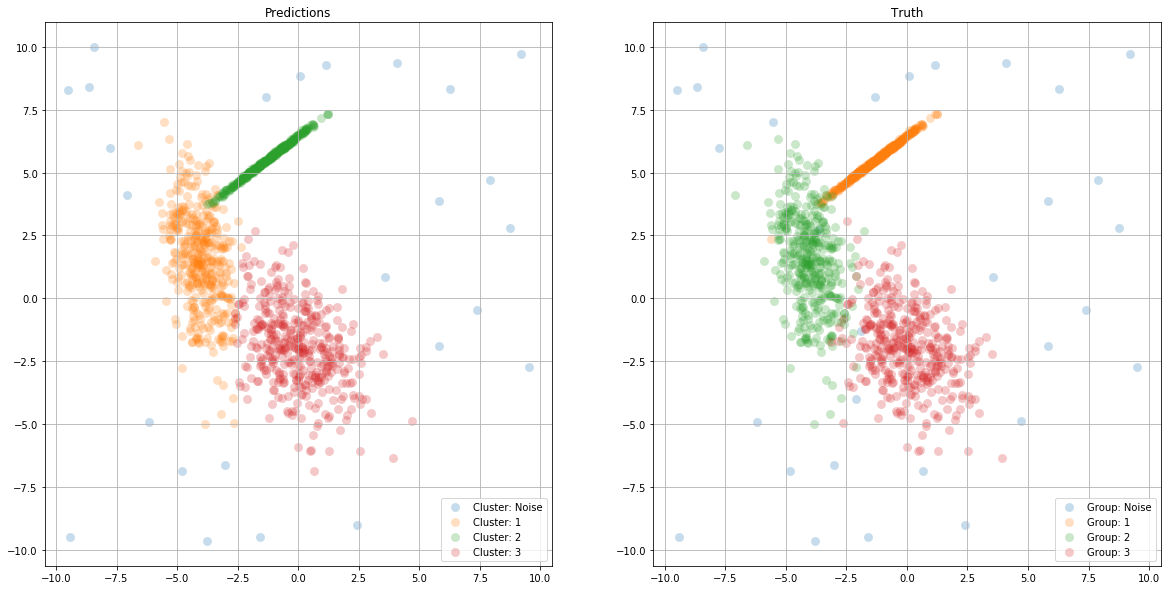

In [139]:
plt.figure(figsize=(20,10))

plt.subplot(121)
for label in np.unique(gmm_eu.labels_):
    data_i = np.array([data[j] for j in range(data.shape[0]) if gmm_eu.labels_[j] == label])
    plt.scatter(data_i.T[0], data_i.T[1], label="Cluster: {}".format(label if label else "Noise"), **plot_kwds)
plt.title("Predictions")
plt.legend()
plt.grid()

plt.subplot(122)
for i, pts in enumerate(X):
    plt.scatter(pts.T[0], pts.T[1], label="Group: {}".format(i if i else "Noise"), **plot_kwds)
plt.title("Truth")
plt.legend()
plt.grid()
plt.show()

It works impressively well !!

### 5 - Modify the my_GMM class to implement the trimmed EM for GMM

In [140]:
class my_GMM_trimmed(my_GMM):
    
    def __init__(self, k, trim, tol=1e-2, itermax=25):
        '''
        Parameters:
        k: integer
            number of components
        tol: float
            convergence tolerance
       
        Attributes:
        
        alpha_: np.array
            proportion of components
        mu_: np.array
            array containing means
        Sigma_: np.array
            array cointaining covariance matrix
        cond_prob_: (n, K) np.array
            conditional probabilities for all data points 
        labels_: (n, ) np.array
            labels for data points
        '''
        self.k_ = k
        self.trim_ = trim
        self.tol_ = tol
        self.itermax_ = itermax
        
        self.alpha_ = None
        self.mu_ = None
        self.Sigma_ = None
        self.cond_prob_ = None
        self.labels_ = None
        
        self.history = {}
    
    def mask_out(self, X, alpha, mu, Sigma, trim):
        n = X.shape[0]
        U = []
        for i in range(n):
            U.append(np.max([alpha[j] * self.gauss_pdf(X[i], mu[j], Sigma[j]) for j in range(self.k_)]))
        U = np.array(U)
        q = np.quantile(U, trim)
        mask = np.array(U >= q)
        return mask
        
    def fit(self, X):
        """ Find the parameters
        that better fit the data
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """    
        self.has_converged = False
        
        # Initialize parameters estimators
        self.alpha_, self.mu_, self.Sigma_ = self.init_params(X, self.k_)
        
        self.history = {"cpm": [], "alpha": [], "mu": [], "Sigma": []}
        
        itr = 0
        while not self.has_converged and itr < self.itermax_:
            itr += 1
            # E-step: compute conditional probability matrix
            self.cond_prob_ = self.compute_proba(X=X, alpha=self.alpha_, mu=self.mu_, Sigma=self.Sigma_)
            
            self.history["cpm"].append(self.cond_prob_)
            self.history["alpha"].append(self.alpha_)
            self.history["mu"].append(self.mu_)
            self.history["Sigma"].append(self.Sigma_)
            
            # M-step: update parameters estimators
            new_alpha = self.update_alpha(cpm=self.cond_prob_)
            
            mask = self.mask_out(X=X, alpha=self.alpha_, mu=self.mu_, Sigma=self.Sigma_, trim=self.trim_)
            R = X[mask]
            cpm_R = self.cond_prob_[mask]
            
            new_mu = self.update_mu(X=R, cpm=cpm_R, alpha=new_alpha)
            new_Sigma = self.update_Sigma(X=R, cpm=cpm_R, alpha=new_alpha, mu=new_mu)
            
            old_params = (self.alpha_, self.mu_, self.Sigma_)
            new_params = (new_alpha, new_mu, new_Sigma)
            
            self.has_converged = self.evaluate_convergence(R, old_params=old_params, new_params=new_params)
            
            self.alpha_ = new_alpha
            self.mu_ = new_mu
            self.Sigma_ = new_Sigma
        
        self.labels_ = self.predict(X)
        return self
        
    def predict(self, X):
        """ Predict labels for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        label assigment        
        """ 
        n= X.shape[0]
        mask = self.mask_out(X=X, alpha=self.alpha_, mu=self.mu_, Sigma=self.Sigma_, trim=self.trim_)
        
        labels = np.argmax(self.cond_prob_, axis=1) + 1
        labels[~mask] = 0
        return labels

In [141]:
data = np.concatenate(X)
gmm_t = my_GMM_trimmed(k=3, trim=0.02, tol=1e-2, itermax=40)
gmm_t.fit(data)

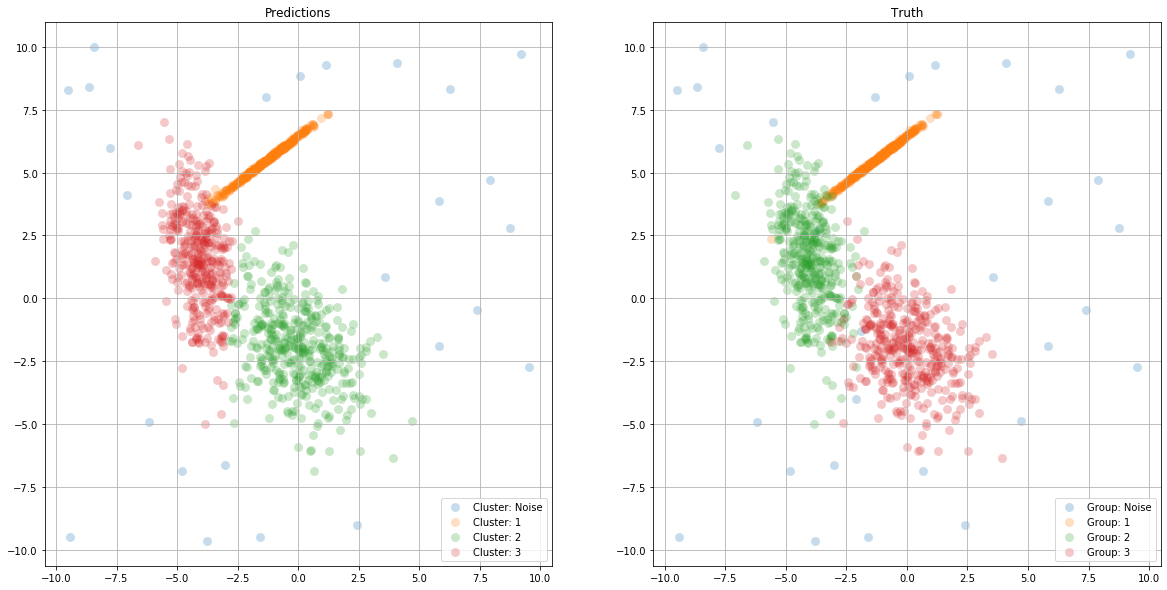

In [142]:
plt.figure(figsize=(20,10))

plt.subplot(121)
for label in np.unique(gmm_t.labels_):
    data_i = np.array([data[j] for j in range(data.shape[0]) if gmm_t.labels_[j] == label])
    plt.scatter(data_i.T[0], data_i.T[1], label="Cluster: {}".format(label if label else "Noise"), **plot_kwds)
plt.title("Predictions")
plt.legend()
plt.grid()

plt.subplot(122)
for i, pts in enumerate(X):
    plt.scatter(pts.T[0], pts.T[1], label="Group: {}".format(i if i else "Noise"), **plot_kwds)
plt.title("Truth")
plt.legend()
plt.grid()
plt.show()

### 6 - Compare the 4 methods in one example

We will use the representation property seen in class :
If one has : 
$$
\left\{
\begin{array}{}
Y \sim t_p(\mu,\Sigma,\nu)\\
g_i \sim \mathcal{N}(0,I_m)\\
AA^T = \Sigma\\
u \sim \Gamma(\nu/2,\nu/2)\\
\end{array}{}
\right.
$$

If $\nu > 2$, then $E[Y^2] < \infty$

And thus : $$Y = \mu + \frac{1}{\sqrt u}Ag$$

We will build the dataset according to this formula.

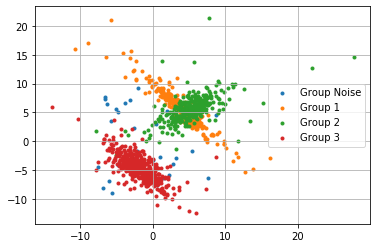

In [147]:
n = 500
p = 2

X = [np.random.uniform(-10, 10, size=(30, p))]

for k in range(3):
    mu = np.random.uniform(-6,6, (2,))
    A = np.random.uniform(-2,2, (2,2))
    dof = 1+np.random.random()*10
    sigma = sigma.T@sigma
    pts = []
    n = np.random.randint(300, 600)
    for _ in range(n):
        g = np.random.multivariate_normal(mean=[0,0], cov=np.eye(2))
        u = np.random.gamma(dof/2, 2/dof)
        pts.append(mu + A@g / np.sqrt(u))
    X.append(np.array(pts))

for i, pts in enumerate(X):
    plt.scatter(pts.T[0], pts.T[1], marker='.', label='Group {}'.format(i if i else "Noise"))
plt.legend()
plt.grid()
plt.show()
data = np.concatenate(X)

In [148]:
model_tmm = my_tMM(3, itermax = 10, tol = 10**-5)
model_gmm_eu = my_GMM_EU(3, itermax=10)
model_gmm_trim = my_GMM_trimmed(3, trim=0.02, itermax=10)

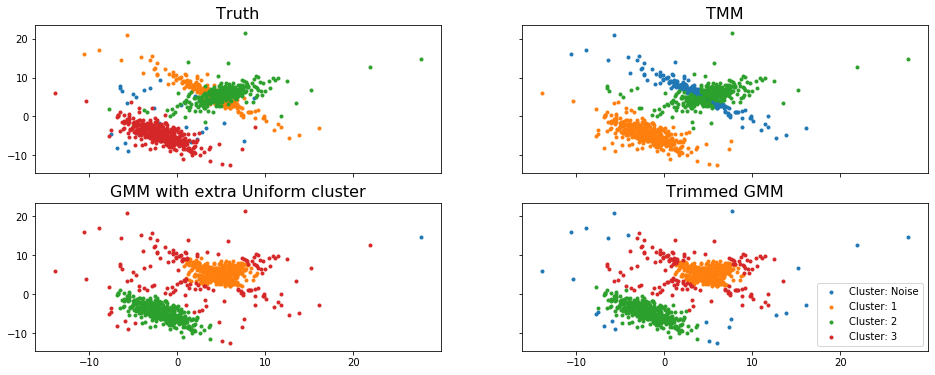

In [149]:
model_tmm.fit(data)
model_gmm_eu.fit(data)
model_gmm_trim.fit(data)

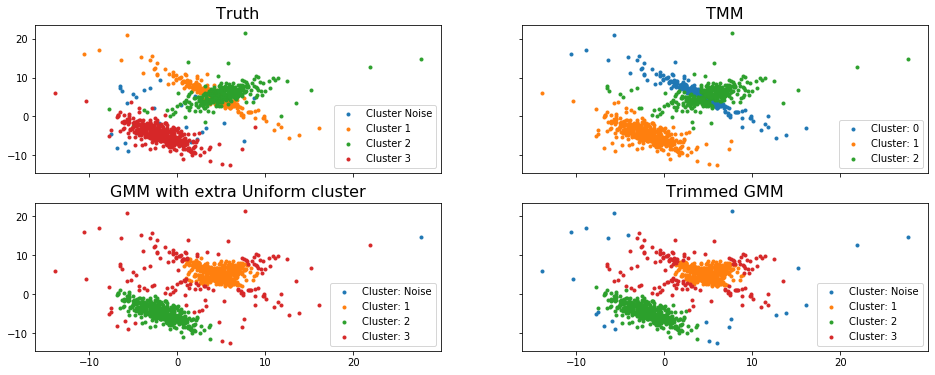

In [153]:
fig, ax = plt.subplots(2, 2, figsize=(16, 6), sharex = True, sharey = True)

for i, pts in enumerate(X):
    ax[0][0].scatter(pts.T[0], pts.T[1], marker='.', label='Cluster {}'.format(i if i else "Noise"))
ax[0][0].set_title('Truth', size=16)
ax[0][0].legend()

for label in np.unique(model_tmm.labels_):
    data_i = np.array([data[j] for j in range(data.shape[0]) if model_tmm.labels_[j] == label])
    ax[0][1].scatter(data_i.T[0], data_i.T[1], marker='.', label="Cluster: {}".format(label))
ax[0][1].set_title('TMM', size = 16)
ax[0][1].legend()

for label in np.unique(model_gmm_eu.labels_):
    data_i = np.array([data[j] for j in range(data.shape[0]) if model_gmm_eu.labels_[j] == label])
    ax[1][0].scatter(data_i.T[0], data_i.T[1], marker='.',label="Cluster: {}".format(label if label else "Noise"))
ax[1][0].set_title('GMM with extra Uniform cluster', size = 16)
ax[1][0].legend()


for label in np.unique(model_gmm_trim.labels_):
    data_i = np.array([data[j] for j in range(data.shape[0]) if model_gmm_trim.labels_[j] == label])
    ax[1][1].scatter(data_i.T[0], data_i.T[1], marker='.', label="Cluster: {}".format(label if label else "Noise"))
ax[1][1].set_title('Trimmed GMM', size = 16)
ax[1][1].legend()

plt.show()

On this particular dataset, Trimmed GMM and GMM with an extra Uniform Cluster have disappointing performances at spotting the shape of the clusters. 

However, tMM performs pretty well at this task.

##### What are the results on the data of the second lab ? (DBSCAN...)

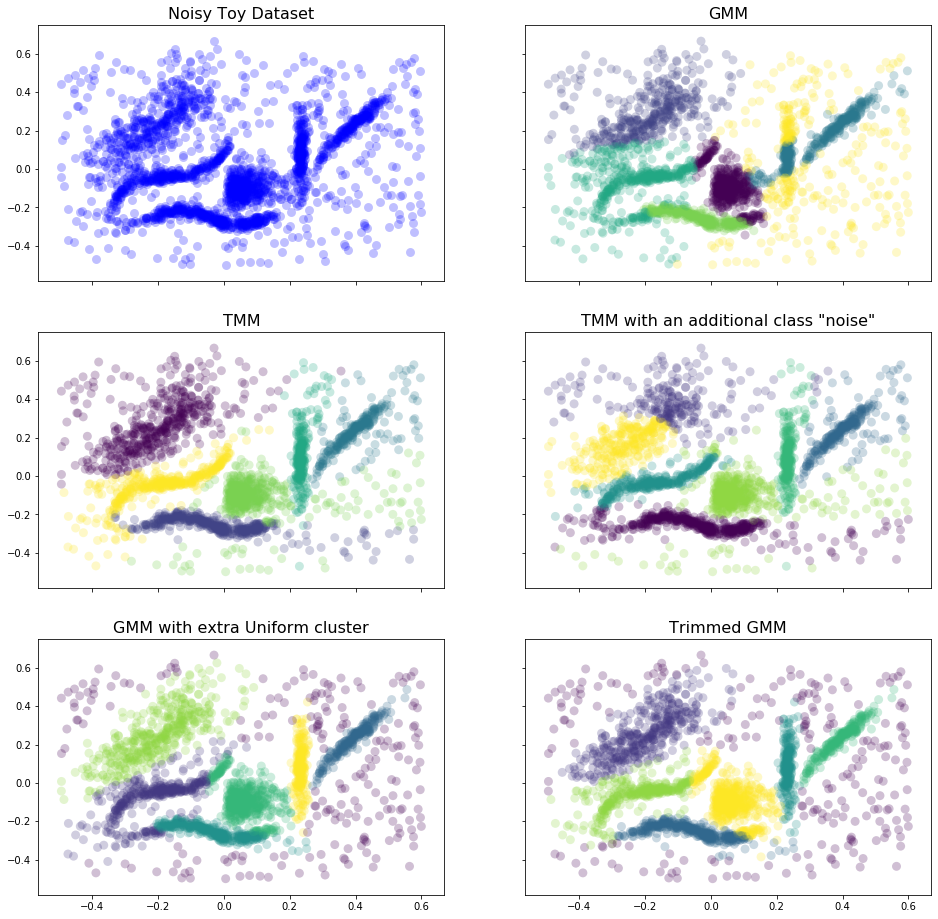

In [146]:
import sklearn.datasets as data

X = np.load('clusterable_data-1.npy')
model_tmm = my_tMM(6, itermax = 15, tol = 10**-5)
model_tmm_add = my_tMM(7, itermax = 15, tol = 10**-5)
model_gmm = my_GMM(6)
model_gmm_eu = my_GMM_EU(6, itermax=15)
model_gmm_trim = my_GMM_trimmed(6, trim=0.1, itermax=15)

model_tmm.fit(X)
model_tmm_add.fit(X)
model_gmm.fit(X)
model_gmm_eu.fit(X)
model_gmm_trim.fit(X)

fig, ax = plt.subplots(3, 2, figsize=(16, 16), sharex = True, sharey = True)

ax[0][0].scatter(X.T[0], X.T[1], color='b', **plot_kwds)
ax[0][0].set_title('Noisy Toy Dataset', size=16)
ax[0][1].scatter(X[:, 0].T, X[:, 1].T, c=model_gmm.labels_, **plot_kwds)
ax[0][1].set_title('GMM', size = 16)
ax[1][0].scatter(X[:, 0].T, X[:, 1].T, c=model_tmm.labels_, **plot_kwds)
ax[1][0].set_title('TMM', size = 16)
ax[1][1].scatter(X[:, 0].T, X[:, 1].T, c=model_tmm_add.labels_, **plot_kwds)
ax[1][1].set_title('TMM with an additional class "noise"', size = 16)
ax[2][0].scatter(X[:, 0].T, X[:, 1].T, c=model_gmm_eu.labels_, **plot_kwds)
ax[2][0].set_title('GMM with extra Uniform cluster', size = 16)
ax[2][1].scatter(X[:, 0].T, X[:, 1].T, c=model_gmm_trim.labels_, **plot_kwds)
ax[2][1].set_title('Trimmed GMM', size = 16)

plt.show();

###### Conclusion

First of all, all the medthods work impressively well ! 
   - GMM doesn't work that well on this dataset but its results are highly improved by the Uniform Cluster. 
   - This last technique works very well on this data because we clearly see a noise in the background which is taken into account by the model. This ends up in a better clustering of data, as it isn't influenced by the noise when building the groups. 
   - The Trimmed GMM takes into account a part of the noise corresponding to the most outlying data which is good. But this technique keeps the drawback of the GMM in the clustering...
   - The TMM yields great results in clustering the data, but with this dataset it is not as good as before because the noise is really huge and should probably be considered as a class.

Our codes take far too much time to execute... Our next step would be to investigate the code using time.time() around every operation to figure out what costs the most. Perhaps using numpy arrays every where and working only with operations over arrays could save us much time. But as we tried this, we realized that it created a code really not readable with many np.newaxis. Thus, we chose to keep our code clean and leave the execution time issue as a step to go further.

**BONUS (not graded):** Implement the trimming EM clustering algorithm TCLUST (https://arxiv.org/pdf/0806.2976.pdf) 